# **CNN Cancer detection - Mini project (Deep Learning - week3)**

## > Projectct overview
The objective is explore the identification of cancer in the set of images provided. 

@github:
[https://github.com/tiubak/MS_AI_DeepLearning_w3](https://github.com/tiubak/MS_AI_DeepLearning_w3)

**It should contain 3 deliverables:**
 * Jputer notebook
 * Public github repository
 * Screenshot of Kagle copetition leaderboard.

Plan: 
 * Exploratory Data Analysis
 * Setup model
 * Train and validate model
 * Output submission

## > Exploratory Data Analysis (EDA)

1. Load modules
   

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import keras,cv2,os
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D
from tqdm.notebook import tqdm
from tqdm import trange
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
print('Import complete')

2025-08-25 10:07:01.238381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756116421.420754      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756116421.479021      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Import complete


2. Load files and labels

In [2]:
train_p = '/kaggle/input/histopathologic-cancer-detection/train/'
#labels
labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv") 
#print(glob(os.path.join(train_p,'*.tif')))
# load .tif files
df = pd.DataFrame({'path': glob(os.path.join(train_p,'*.tif'))})

df['id'] = df.path.map(lambda x: x.split('/')[5].split(".")[0]) # file filename on id
df = df.merge(labels, on = "id")
df.head(3)
print('Loaded!')

Loaded!


220k training images and 57k

3. Import images (define small N to speedup)

In [3]:
N=len(df)
X = np.zeros([N,96,96,3],dtype=np.uint8) 
y = df['label'].to_numpy()[0:N]
for i, row in tqdm(df.iterrows(), total=N):
    if i == N:
        break
    X[i] = cv2.imread(row['path'])

print('df Images created')

  0%|          | 0/220025 [00:00<?, ?it/s]

df Images created


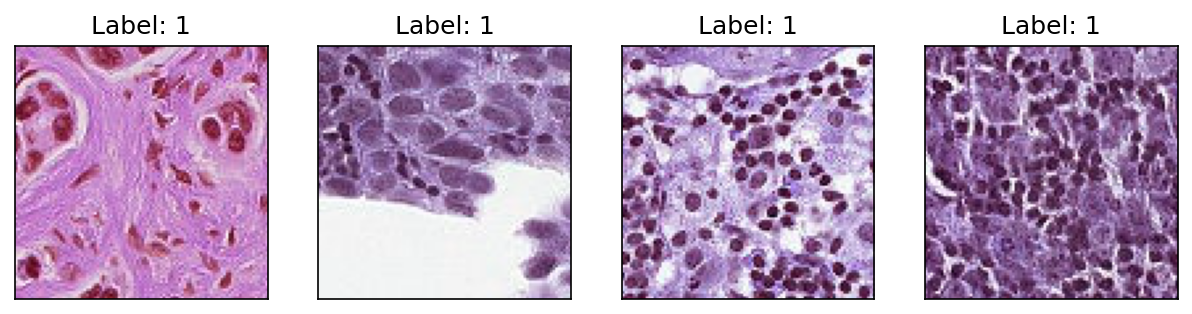

In [4]:
#plot couple images
fig = plt.figure(figsize=(10, 4), dpi=150)
for plotNr,idx in enumerate(np.random.randint(0,N,4)):
    ax = fig.add_subplot(1, 4, plotNr+1, xticks=[], yticks=[])
    plt.imshow(X[idx])
    ax.set_title('Label: ' + str(y[idx]))

4. Check distribution

In [5]:
positive = X[y == 1]
negative = X[y == 0]
print("Positive: "+str(len(positive)))
print("Negative: "+str(len(negative)))


Positive: 89117
Negative: 130908


## > Create the model

In [6]:
trainingPerc = 0.8
split = int(np.round(trainingPerc * y.shape[0]))

np.random.seed(42)

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]
print('Suffle')

Suffle


In [7]:
kernel = (3,3)
pool= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.5

#model example mixed from other solutions available at Kaggle

model = Sequential([
    Input(shape=(96, 96, 3)),
    # 1st block
    Conv2D(first_filters, kernel),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(first_filters, kernel, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(pool_size = pool), 
    Dropout(dropout_conv),
    # 2nd block
    Conv2D(second_filters, kernel, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(second_filters, kernel, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(pool_size = pool),
    Dropout(dropout_conv),
    # 3rd block
    Conv2D(third_filters, kernel, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(third_filters, kernel, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(pool_size = pool),
    Dropout(dropout_conv),
    # Dense layer
    Flatten(),
    Dense(256, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Dropout(dropout_dense),
    # Sigmoid function
    Dense(1, activation = "sigmoid")
])

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

print('Model created')

I0000 00:00:1756118882.538300      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model created


Train model

In [8]:
batch=100
for epoch in range(3):  # 3 epchs 
    iterations = np.floor(split / batch).astype(int)
    loss,acc = 0,0 
    with trange(iterations) as t: 
        for i in t:
            start_idx = i * batch 
            x_batch = X[start_idx:start_idx+batch] 
            y_batch = y[start_idx:start_idx+batch] 
            metrics = model.train_on_batch(x_batch, y_batch) 
            loss = loss + metrics[0] 
            acc = acc + metrics[1] 
            t.set_description('Running training epoch ' + str(epoch)) 
            t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) 

print('Trainning complete!')

  0%|          | 0/1760 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1756118888.566611      19 service.cc:148] XLA service 0x2e45d460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756118888.567302      19 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756118889.181571      19 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756118897.619438      19 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Running training epoch 2: 100%|██████████| 1760/1760 [01:02<00:00, 28.37it/s, acc=0.88, loss=0.29]

Trainning complete!


Verify the model

In [9]:
iterations = np.floor((y.shape[0]-split) / batch).astype(int)
loss,acc = 0,0
with trange(iterations) as t: 
    for i in t:
        start_idx = i * batch
        x_batch = X[start_idx:start_idx+batch] 
        y_batch = y[start_idx:start_idx+batch]
        
        metrics = model.test_on_batch(x_batch, y_batch)
        
        loss = loss + metrics[0]
        acc = acc + metrics[1]
        t.set_description('Running training')
        t.set_description('Running validation')
        t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))
        
print("Validation loss:",loss / iterations)
print("Validation accuracy:",acc / iterations)

Running validation: 100%|██████████| 440/440 [00:05<00:00, 73.96it/s, acc=0.88, loss=0.30]


Validation loss: 0.29739099300720473
Validation accuracy: 0.8806857427412813


## > Submission

In [10]:
print('Starting prediction!')
test_p = '/kaggle/input/histopathologic-cancer-detection/test/'
test_f = glob(os.path.join(test_p,'*.tif'))
submission_list = []
batch_size = 1000 

for idx in tqdm(range(0, len(test_f), batch_size), desc="Processing batches"):
    batch_paths = test_f[idx:idx + batch_size]
    batch_images = [cv2.imread(path) for path in batch_paths]
    batch_df = pd.DataFrame({
        'path': batch_paths,
        'id': [path.split('/')[5].split(".")[0] for path in batch_paths]
    })
    K_test = np.stack(batch_images)
    batch_df['label'] = model.predict(K_test, verbose=0)
    submission_list.append(batch_df[["id", "label"]])
submission = pd.concat(submission_list, ignore_index=True)
print("Processing complete.")
submission.to_csv("submission.csv", index = False, header = True)
print("submission.csv saved")

Starting prediction!


Processing batches:   0%|          | 0/58 [00:00<?, ?it/s]

Processing complete.
submission.csv saved
